<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle
import bs4 as bs
import urllib
import re

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional

### Datos
Utilizaremos como dataset libros del site gutember.org en el idioma inglés.

In [2]:
pages = [
    # "https://www.gutenberg.org/cache/epub/70828/pg70828-images.html",
    # 'https://www.gutenberg.org/cache/epub/70829/pg70829-images.html',
    # "https://www.gutenberg.org/cache/epub/70827/pg70827-images.html",
    # "https://www.gutenberg.org/cache/epub/70826/pg70826-images.html",
    # "https://www.gutenberg.org/cache/epub/70825/pg70825-images.html",
    # "https://www.gutenberg.org/cache/epub/70824/pg70824-images.html",
    #"https://www.gutenberg.org/cache/epub/70823/pg70823-images.html",
    #"https://www.gutenberg.org/cache/epub/70822/pg70822-images.html",
    "https://www.gutenberg.org/cache/epub/70821/pg70821-images.html",
    "https://www.gutenberg.org/cache/epub/70820/pg70820-images.html"
]

In [3]:
def get_page_text(url):
    raw_html = urllib.request.urlopen(url)
    raw_html = raw_html.read()

    article_html = bs.BeautifulSoup(raw_html, 'lxml')

    article_paragraphs = article_html.find_all('p', attrs={"class": None})

    text = []

    for p in article_paragraphs:
        if len(p.text) > 100:
            text.append(p.text)

    return text


In [4]:
text = []

for page in pages:
    content = get_page_text(page)
    print(len(content))
    text += content

len(text)

1529
1877


3406

### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [5]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
#from keras.utils import pad_sequences # se utilizará para padding
from keras_preprocessing.sequence import pad_sequences

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [6]:
# Ejemplo de como transformar una oración a tokens usando keras
text[0]

'Credits: Laurent Vogel, Pierre Lacaze and the Online Distributed Proofreading Team at https://www.pgdp.net (This file was produced from images generously made available by the Bibliothèque nationale de France (BnF/Gallica))'

In [7]:
tokens = text_to_word_sequence(text[0]) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['credits',
 'laurent',
 'vogel',
 'pierre',
 'lacaze',
 'and',
 'the',
 'online',
 'distributed',
 'proofreading',
 'team',
 'at',
 'https',
 'www',
 'pgdp',
 'net',
 'this',
 'file',
 'was',
 'produced',
 'from',
 'images',
 'generously',
 'made',
 'available',
 'by',
 'the',
 'bibliothèque',
 'nationale',
 'de',
 'france',
 'bnf',
 'gallica']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [8]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for row in text:
    sentence_tokens.append(text_to_word_sequence(row))

In [9]:
# Demos un vistazo
sentence_tokens[:2]

[['credits',
  'laurent',
  'vogel',
  'pierre',
  'lacaze',
  'and',
  'the',
  'online',
  'distributed',
  'proofreading',
  'team',
  'at',
  'https',
  'www',
  'pgdp',
  'net',
  'this',
  'file',
  'was',
  'produced',
  'from',
  'images',
  'generously',
  'made',
  'available',
  'by',
  'the',
  'bibliothèque',
  'nationale',
  'de',
  'france',
  'bnf',
  'gallica'],
 ['«je',
  'ne',
  "m'inquiète",
  'pas',
  'si',
  'les',
  'oiseaux',
  'volent',
  'à',
  'ma',
  'droite\r',
  'du',
  'côté',
  'de',
  "l'aurore",
  'et',
  'du',
  'soleil',
  'ou',
  'à',
  'ma',
  'gauche',
  'vers\r',
  'les',
  'ténèbres',
  'immenses',
  'le',
  'meilleur',
  'des',
  'augures',
  'est',
  'le\r',
  'combat',
  'pour',
  'la',
  'patrie',
  '»']]

In [10]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [11]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['credits', 'laurent', 'vogel', 'pierre'],
 ['laurent', 'vogel', 'pierre', 'lacaze'],
 ['vogel', 'pierre', 'lacaze', 'and'],
 ['pierre', 'lacaze', 'and', 'the'],
 ['lacaze', 'and', 'the', 'online'],
 ['and', 'the', 'online', 'distributed'],
 ['the', 'online', 'distributed', 'proofreading'],
 ['online', 'distributed', 'proofreading', 'team'],
 ['distributed', 'proofreading', 'team', 'at'],
 ['proofreading', 'team', 'at', 'https'],
 ['team', 'at', 'https', 'www'],
 ['at', 'https', 'www', 'pgdp'],
 ['https', 'www', 'pgdp', 'net'],
 ['www', 'pgdp', 'net', 'this'],
 ['pgdp', 'net', 'this', 'file'],
 ['net', 'this', 'file', 'was'],
 ['this', 'file', 'was', 'produced'],
 ['file', 'was', 'produced', 'from'],
 ['was', 'produced', 'from', 'images'],
 ['produced', 'from', 'images', 'generously'],
 ['from', 'images', 'generously', 'made'],
 ['images', 'generously', 'made', 'available'],
 ['generously', 'made', 'available', 'by'],
 ['made', 'available', 'by', 'the'],
 ['available', 'by', 'the', 'b

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [12]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [13]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[30, 28, 26, 2],
 [28, 26, 2, 3],
 [26, 2, 3, 4],
 [2, 3, 4, 1],
 [3, 4, 1, 5],
 [4, 1, 5, 6],
 [1, 5, 6, 7],
 [5, 6, 7, 8],
 [6, 7, 8, 9],
 [7, 8, 9, 10],
 [8, 9, 10, 11],
 [9, 10, 11, 12],
 [10, 11, 12, 13],
 [11, 12, 13, 14],
 [12, 13, 14, 15],
 [13, 14, 15, 16],
 [14, 15, 16, 17],
 [15, 16, 17, 18],
 [16, 17, 18, 19],
 [17, 18, 19, 20],
 [18, 19, 20, 21],
 [19, 20, 21, 22],
 [20, 21, 22, 23],
 [21, 22, 23, 1],
 [22, 23, 1, 24],
 [23, 1, 24, 25],
 [1, 24, 25, 27],
 [24, 25, 27, 29],
 [25, 27, 29, 31]]

In [14]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

29


In [15]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

31


In [16]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'pierre': 2, 'lacaze': 3, 'and': 4, 'online': 5, 'distributed': 6, 'proofreading': 7, 'team': 8, 'at': 9, 'https': 10, 'www': 11, 'pgdp': 12, 'net': 13, 'this': 14, 'file': 15, 'was': 16, 'produced': 17, 'from': 18, 'images': 19, 'generously': 20, 'made': 21, 'available': 22, 'by': 23, 'bibliothèque': 24, 'nationale': 25, 'vogel': 26, 'de': 27, 'laurent': 28, 'france': 29, 'credits': 30, 'bnf': 31}


In [17]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'vogel': 3, 'credits': 1, 'pierre': 4, 'laurent': 2, 'lacaze': 4, 'and': 4, 'the': 8, 'online': 4, 'distributed': 4, 'proofreading': 4, 'team': 4, 'at': 4, 'https': 4, 'www': 4, 'pgdp': 4, 'net': 4, 'this': 4, 'file': 4, 'was': 4, 'produced': 4, 'from': 4, 'images': 4, 'generously': 4, 'made': 4, 'available': 4, 'by': 4, 'bibliothèque': 4, 'nationale': 4, 'de': 3, 'france': 2, 'bnf': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [18]:
# Vistazo a las primeras filas
text[:15]

['Credits: Laurent Vogel, Pierre Lacaze and the Online Distributed Proofreading Team at https://www.pgdp.net (This file was produced from images generously made available by the Bibliothèque nationale de France (BnF/Gallica))',
 "«Je ne m'inquiète pas si les oiseaux volent à ma droite\r\ndu côté de l'aurore et du soleil, ou à ma gauche vers\r\nles ténèbres immenses: le meilleur des augures est le\r\ncombat pour la patrie.»",
 "Je venais de traverser la Perse, du Caucase au golfe Persique, de la Gédrosie à\r\nla Susiane, lorsque je pris, à Bouchyr, le bateau qui devait me rapatrier. Les\r\nhautes montagnes du Fars s'évanouissaient à l'horizon; je leur dis un adieu que\r\nje croyais éternel. Fatigués, malades, anémiés par la fièvre, M. Dieulafoy et moi\r\nrevînmes en France avec le ferme dessein de ne plus nous désaltérer à des[Pg 2]\r\nsources étrangères. Peut-être devions-nous cette torpeur morale à un état de santé\r\nfort précaire.",
 "Six mois plus tard, je songeais aux naïades de l

In [19]:
len(text)

3406

In [20]:
# Concatenamos todos los rows en un solo valor
corpus = ''.join(text)
corpus

"Credits: Laurent Vogel, Pierre Lacaze and the Online Distributed Proofreading Team at https://www.pgdp.net (This file was produced from images generously made available by the Bibliothèque nationale de France (BnF/Gallica))«Je ne m'inquiète pas si les oiseaux volent à ma droite\r\ndu côté de l'aurore et du soleil, ou à ma gauche vers\r\nles ténèbres immenses: le meilleur des augures est le\r\ncombat pour la patrie.»Je venais de traverser la Perse, du Caucase au golfe Persique, de la Gédrosie à\r\nla Susiane, lorsque je pris, à Bouchyr, le bateau qui devait me rapatrier. Les\r\nhautes montagnes du Fars s'évanouissaient à l'horizon; je leur dis un adieu que\r\nje croyais éternel. Fatigués, malades, anémiés par la fièvre, M. Dieulafoy et moi\r\nrevînmes en France avec le ferme dessein de ne plus nous désaltérer à des[Pg 2]\r\nsources étrangères. Peut-être devions-nous cette torpeur morale à un état de santé\r\nfort précaire.Six mois plus tard, je songeais aux naïades de l'Iran: le souven

In [21]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['credits',
 'laurent',
 'vogel',
 'pierre',
 'lacaze',
 'and',
 'the',
 'online',
 'distributed',
 'proofreading',
 'team',
 'at',
 'https',
 'www',
 'pgdp',
 'net',
 'this',
 'file',
 'was',
 'produced']

In [22]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 190837


In [23]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [24]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['credits', 'laurent', 'vogel', 'pierre'],
 ['laurent', 'vogel', 'pierre', 'lacaze'],
 ['vogel', 'pierre', 'lacaze', 'and'],
 ['pierre', 'lacaze', 'and', 'the'],
 ['lacaze', 'and', 'the', 'online'],
 ['and', 'the', 'online', 'distributed'],
 ['the', 'online', 'distributed', 'proofreading'],
 ['online', 'distributed', 'proofreading', 'team'],
 ['distributed', 'proofreading', 'team', 'at'],
 ['proofreading', 'team', 'at', 'https'],
 ['team', 'at', 'https', 'www'],
 ['at', 'https', 'www', 'pgdp'],
 ['https', 'www', 'pgdp', 'net'],
 ['www', 'pgdp', 'net', 'this'],
 ['pgdp', 'net', 'this', 'file'],
 ['net', 'this', 'file', 'was'],
 ['this', 'file', 'was', 'produced'],
 ['file', 'was', 'produced', 'from'],
 ['was', 'produced', 'from', 'images'],
 ['produced', 'from', 'images', 'generously']]

In [25]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[26957, 26956, 26955, 663],
 [26956, 26955, 663, 12287],
 [26955, 663, 12287, 3],
 [663, 12287, 3, 1],
 [12287, 3, 1, 12288],
 [3, 1, 12288, 5899],
 [1, 12288, 5899, 12289],
 [12288, 5899, 12289, 12290],
 [5899, 12289, 12290, 37],
 [12289, 12290, 37, 12291],
 [12290, 37, 12291, 12292],
 [37, 12291, 12292, 12293],
 [12291, 12292, 12293, 7971],
 [12292, 12293, 7971, 108],
 [12293, 7971, 108, 3273],
 [7971, 108, 3273, 16],
 [108, 3273, 16, 3274],
 [3273, 16, 3274, 53],
 [16, 3274, 53, 7972],
 [3274, 53, 7972, 12294]]

In [26]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 190833


### 3 - Input y target

In [27]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [28]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [29]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [30]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(190833, 3)
(190833,)


In [31]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'de',
 3: 'and',
 4: 'la',
 5: 'les',
 6: 'of',
 7: 'a',
 8: 'to',
 9: 'le',
 10: 'et',
 11: '\r',
 12: 'des',
 13: 'à',
 14: 'in',
 15: 'his',
 16: 'was',
 17: 'he',
 18: 'on',
 19: 'du',
 20: 'had',
 21: 'un',
 22: 'jack',
 23: 'with',
 24: 'they',
 25: 'une',
 26: 'were',
 27: 'que',
 28: '’',
 29: 'nous',
 30: 'dans',
 31: 'the\r',
 32: 'il',
 33: 'en',
 34: 'that',
 35: 'se',
 36: 'ne',
 37: 'at',
 38: 'sur',
 39: 'au',
 40: 'for',
 41: 'as',
 42: 'their',
 43: 'him',
 44: 'it',
 45: 'you',
 46: 'qui',
 47: 'pas',
 48: 'est',
 49: 'but',
 50: 'said',
 51: 'up',
 52: 'plus',
 53: 'from',
 54: 'them',
 55: 'by',
 56: 'par',
 57: 'i',
 58: 'je',
 59: 'then',
 60: 'who',
 61: 'me',
 62: 'which',
 63: 'be',
 64: 'sont',
 65: 'one',
 66: 'all',
 67: 'pour',
 68: 'son',
 69: 'aux',
 70: 'de\r',
 71: 'avec',
 72: 'ses',
 73: 'men',
 74: 'when',
 75: 'out',
 76: 'not',
 77: 'ce',
 78: "d'un",
 79: 'leur',
 80: 'been',
 81: 'will',
 82: 'mais',
 83: 'si',
 84: 'have',
 85: "d

In [32]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

26957

In [33]:
# Transformar los datos a oneHotEncoding
#y_data = to_categorical(y_data_int, num_classes=vocab_size)
y_data = to_categorical(y_data_int)

In [34]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [35]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(190833, 26957)

### 4 - Entrenar el modelo

In [36]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [37]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

26957

In [38]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

#model.add(LSTM(64, return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
#model.add(Dense(32, activation='relu'))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

2023-05-22 19:36:38.557610: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-05-22 19:36:38.557652: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: pop-os
2023-05-22 19:36:38.557657: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: pop-os
2023-05-22 19:36:38.557797: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.105.17
2023-05-22 19:36:38.557818: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.105.17
2023-05-22 19:36:38.557820: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.105.17
2023-05-22 19:36:38.558712: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              134790    
                                                                 
 bidirectional (Bidirectiona  (None, 3, 128)           35840     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 26957)             1752205   
                                                                 
Total params: 1,964,051
Trainable params: 1,964,051
Non-trainable params: 0
_________________________________________________________________


In [39]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50


2023-05-22 19:36:39.054442: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16461669448 exceeds 10% of free system memory.


4767/4771 [============================>.] - ETA: 0s - loss: 8.1447 - accuracy: 0.0326

2023-05-22 19:37:41.494499: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4115471276 exceeds 10% of free system memory.


4771/4771 [==============================] - 63s 13ms/step - loss: 8.1448 - accuracy: 0.0326 - val_loss: 7.7557 - val_accuracy: 0.0559
Epoch 2/50
4771/4771 [==============================] - 61s 13ms/step - loss: 7.2516 - accuracy: 0.0603 - val_loss: 7.0886 - val_accuracy: 0.0691
Epoch 3/50
4771/4771 [==============================] - 59s 12ms/step - loss: 6.8466 - accuracy: 0.0711 - val_loss: 7.0758 - val_accuracy: 0.0817
Epoch 4/50
4771/4771 [==============================] - 58s 12ms/step - loss: 6.5604 - accuracy: 0.0828 - val_loss: 7.0856 - val_accuracy: 0.0944
Epoch 5/50
4771/4771 [==============================] - 58s 12ms/step - loss: 6.2991 - accuracy: 0.0927 - val_loss: 7.0981 - val_accuracy: 0.0976
Epoch 6/50
4771/4771 [==============================] - 61s 13ms/step - loss: 6.0685 - accuracy: 0.1015 - val_loss: 7.1552 - val_accuracy: 0.0978
Epoch 7/50
4771/4771 [==============================] - 62s 13ms/step - loss: 5.8419 - accuracy: 0.1084 - val_loss: 7.1932 - val_accura

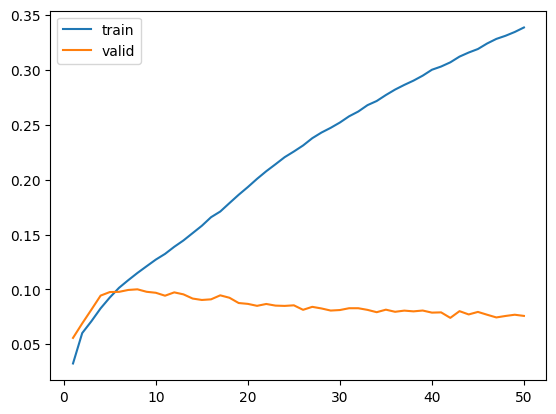

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [41]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [42]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [43]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/home/rafael/miniconda3/envs/ceia_nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rafael/miniconda3/envs/ceia_nlp/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


### 6 - Generación de secuencias nuevas

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='hey jude don\'t'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

"hey jude don't et the"

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.